<a href="https://www.kaggle.com/code/mohdmuttalib/rsna-eda?scriptVersionId=130071320" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import os
from pathlib import Path

import random

import glob as gb  
import pydicom as dicom
from pydicom import dcmread

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from IPython.display import display_html

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



In [2]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
test = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

## Data Analysis

In [3]:
print('Train Data')
display(train.head())
print('Test Data')
test.head()

Train Data


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Test Data


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [4]:
print(f"\033[1mNumber of records in the dataset is : {train.shape[0]}, and number of Unique Records : {train.patient_id.nunique()}\033[0m")

Number of records in the dataset is : 54706, and number of Unique Records : 11913


In [5]:
train.isnull().sum().to_frame(name='Number of Null Values').style.background_gradient(cmap='afmhot_r')

,Number of Null Values
site_id,0
patient_id,0
image_id,0
laterality,0
view,0
age,37
cancer,0
biopsy,0
invasive,0
BIRADS,28420


In [6]:
test.isnull().sum().sum()

0

traning data have BIRADS, density have more than 45% null values, test data there is no null value

# Age Analysis

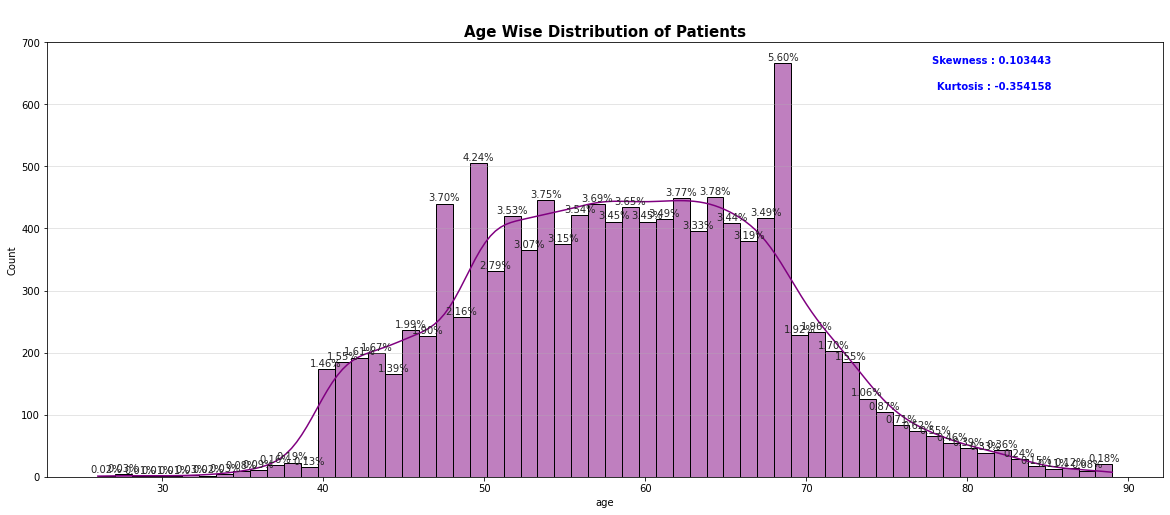

In [7]:
age_df = train[train.age.isnull() == False].groupby('patient_id')['age'].apply(lambda x: (np.unique(x)[0]))

plt.figure(figsize=(20,8))
ax = sns.histplot(age_df, bins=60,kde=True,color='purple') 
ax.grid(axis='y', linestyle='-', alpha=0.4) 

sns.set_style("whitegrid")
ax.text(x=0.9, y=0.97, transform=ax.transAxes, s="Skewness : %f" % age_df.skew(),fontsize=10, color='blue', fontweight='bold', verticalalignment='top', horizontalalignment='right')
ax.text(x=0.9, y=0.91, transform=ax.transAxes, s="Kurtosis : %f" % age_df.kurt(),fontsize=10, color='blue', fontweight='bold', verticalalignment='top', horizontalalignment='right')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / age_df.shape[0]:.2f}%\n'
    plt.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
    ax.set_title("\nAge Wise Distribution of Patients", fontsize=15, fontweight='bold')

plt.show()

In [8]:
fig = px.box(age_df)
fig.show()

* Age is having a positive skew but of only 0.103443 and kurtosis as -0.354158 
* Age is having median value 59, and there is a peek in age between 67-69.

## Cancer Status Analysis

In [9]:
def highlightcol(val):
    if val == 1:
        color = 'red'
    elif val == 0:
        color = 'green'
    else:
        color = 'orange'
    return 'color: %s' % color

In [10]:
non_unique = train.groupby('patient_id').cancer.transform('nunique').ne(1)
cancer_notunique = train[non_unique]
#print(cancer_notunique.groupby('patient_id').cancer.nunique().unique())

display_html(f"<h3><br/>There are {cancer_notunique.patient_id.nunique()} paitents, who have cancer values True as well as False ", raw=True)
display_html(f"<h4><br/>Sample data", raw= True)
display(cancer_notunique[cancer_notunique['patient_id']==cancer_notunique.patient_id.unique()[0]].style.applymap(highlightcol,subset = pd.IndexSlice[:, ['cancer']]))
display_html(f"<h3><br/>As there  is no time data available, analyising this 480 data samples with image id, considering ascending order being maintained for the paitent image id", raw= True)

completely_cured=0;still_have_cancer=0;cured_list=[];still_have_cancer_list=[];

for i in range(len(cancer_notunique.patient_id.unique())):
    if i == len(cancer_notunique.patient_id.unique()):
        count+=1
    list_0 = [];list_1 = [];       
    temp = cancer_notunique[cancer_notunique['patient_id']==cancer_notunique.patient_id.unique()[i]]
    list_0 = temp[temp['cancer']==0]['image_id']
    list_1 = temp[temp['cancer']==1]['image_id']
        
    if(all(i < max(list_0) for i in list_1)):
        completely_cured +=1;cured_list.append(max(list_0))
        
    else:
        still_have_cancer+=1;still_have_cancer_list.append(max(list_1))
        

display_html(f"<h3><br/>Out of this 480 samples, {completely_cured}, are completely cured, and {still_have_cancer}, still have cancer", raw= True)
temp_cured = train[train['image_id'].isin(cured_list)]
fig = go.Figure(data=[go.Table(header=dict(values=temp_cured.columns,fill_color='light gray'),
                 cells=dict(values=[temp_cured],fill_color='lavenderblush'))])
fig = go.Figure(data=[go.Table(header=dict(values=['site_id', 'patient_id', 'image_id','cancer'],fill_color='hotpink'),
                 cells=dict(values=[temp_cured[temp_cured.columns[0]],temp_cured[temp_cured.columns[1]],temp_cured[temp_cured.columns[2]],temp_cured[temp_cured.columns[6]]],fill_color='lightgreen'))])

fig.update_layout(title="Completely cured from 480 samples with latest image_id and cancer status")
                  
fig.show()
temp_uncured = train[train['image_id'].isin(still_have_cancer_list)]
fig = go.Figure(data=[go.Table(header=dict(values=temp_uncured.columns,fill_color='light gray'),
                 cells=dict(values=[temp_cured],fill_color='lavenderblush'))])
fig = go.Figure(data=[go.Table(header=dict(values=['site_id', 'patient_id', 'image_id','cancer'],fill_color='pink'),
                 cells=dict(values=[temp_uncured[temp_uncured.columns[0]],temp_uncured[temp_uncured.columns[1]],temp_uncured[temp_uncured.columns[2]],temp_uncured[temp_uncured.columns[6]]],fill_color='skyblue'))])

fig.update_layout(title="From 480 samples, data of patients who have not cured with latest image_id and cancer status")
                  
fig.show()


There are 480 paitents, who have cancer values True as well as False

Sample data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.000000,1,1,1,0.000000,0,B,49,False
88,1,10130,613462606,L,CC,71.000000,1,1,1,0.000000,0,B,49,False
89,1,10130,1360338805,L,CC,71.000000,1,1,1,0.000000,0,B,49,False
90,1,10130,1672636630,L,MLO,71.000000,1,1,1,0.000000,0,B,49,False
91,1,10130,1013166704,R,CC,71.000000,0,0,0,nan,0,B,49,False
92,1,10130,1165309236,R,CC,71.000000,0,0,0,nan,0,B,49,False
93,1,10130,2110820077,R,MLO,71.000000,0,0,0,nan,0,B,49,False


As there is no time data available, analyising this 480 data samples with image id, considering ascending order being maintained for the paitent image id

Out of this 480 samples, 235, are completely cured, and 245, still have cancer

In [11]:
cancer_unique_df =train[~non_unique]
print(cancer_unique_df.groupby('patient_id').cancer.nunique().unique())
cancer_unique = cancer_unique_df [['patient_id','cancer']]
cancer_unique.drop_duplicates(keep='first',inplace=True)

[1]


In [12]:
counter_0_1_0_1=0;counter_0_0_1_1=0;c_0 =0;c_1=0;list_c_0=[];list_c_1=[];list_counter_0_1_0_1=[];list_counter_0_0_1_1=[];count=0

temp_df = train[train['patient_id'].isin(temp_uncured['patient_id'])][['patient_id','image_id','cancer']]## Creating dataset with uncured patients from 480 samples


for i in range(len(temp_df.patient_id.unique())):
    list_image = temp_df[temp_df['patient_id']==temp_df.patient_id.unique()[i]]['image_id']
    list_0 = temp_df[(temp_df['cancer']==0)&(temp_df['patient_id']==temp_df.patient_id.unique()[i])]['image_id']
    list_1 = temp_df[(temp_df['cancer']==1)&(temp_df['patient_id']==temp_df.patient_id.unique()[i])]['image_id']
    
    c = temp_df[temp_df['image_id']==min(list_image)]['cancer'] # c will have cancer boolen for minimum of image_id for each patient_id
    
    if(c.values[0]==0): # patient with c as False
        c_0+=1;list_c_0.append(temp_df.patient_id.unique()[i]) # Patients with starting 0 then 1 then 0 then 1
        if max(list_0)>min(list_1):
            counter_0_1_0_1+=1;list_counter_0_1_0_1.append(temp_df.patient_id.unique()[i])
        elif max(list_0)<min(list_1):
            counter_0_0_1_1+=1; list_counter_0_0_1_1.append(temp_df.patient_id.unique()[i])
        else:
            count+=1;
            
    else:
        c_1+=1;list_c_1.append(temp_df.patient_id.unique()[i]) # Provide patients having starting 1 and in between 0 and finally then 1
        
    

In [13]:
cancer_df = pd.DataFrame()
#cancer_df['Type Of Patients'] = ['Cancer Stats False from Beginning','Cancer True Status Not Changed', 'Completely Cured','0_1_0_1','0_0_1_1','1_0_1']
cancer_df['Patients Cancer Status'] = ['Cancer Stats False from Beginning','Cancer Stats True from Beginning', 'Completely Cured','Cancer Stats False Turned True then False, Finally True','Cancer Stats Truned True','Cancer Stats True Turned False, Finally True']
cancer_df['Count']=[cancer_unique.cancer.value_counts().values[0],cancer_unique.cancer.value_counts().values[1],completely_cured,counter_0_1_0_1,counter_0_0_1_1,c_1]
cancer_df.set_index(cancer_df.columns[0], inplace=True)

cancer_status_not_Changed = ((11427 + 6)/cancer_df['Count'].sum()*100)

cancer_status_changed  = ((235+90+66+89) /cancer_df['Count'].sum()*100)

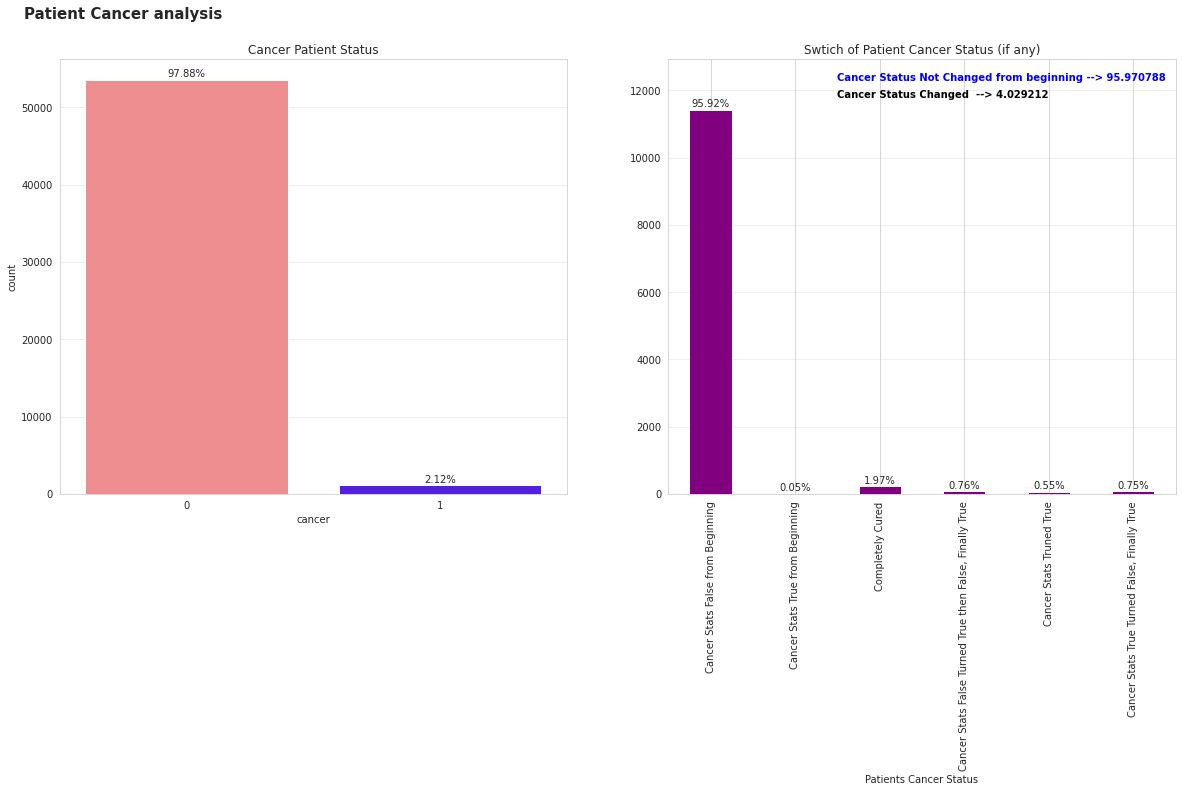

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
fig.text(0.1, 0.95, "Patient Cancer analysis ", fontsize=15, fontweight='bold')  

sns.countplot(x = "cancer",data=train, palette="gnuplot2_r", ax = ax[0])
ax[1] = cancer_df['Count'].plot(kind = "bar",color = 'purple')
    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
    if i==0:t = train.shape[0];ax.set_title('Cancer Patient Status')
    else:
        t = cancer_df['Count'].sum();ax.set_ylim(0, cancer_df['Count'].max()+1500);ax.set_title('Swtich of Patient Cancer Status (if any)')
        ax.text(x=0.98, y=0.97, transform=ax.transAxes, s="Cancer Status Not Changed from beginning --> %f" % cancer_status_not_Changed, fontsize=10, color='blue', fontweight='bold', verticalalignment='top', horizontalalignment='right')
        ax.text(x=0.75, y=0.93, transform=ax.transAxes, s="Cancer Status Changed  --> %f" % cancer_status_changed , fontsize=10, color='black',   fontweight='bold', verticalalignment='top', horizontalalignment='right')
        
        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
        

    
plt.show()

* The dataset has 95.92% of patients with cancer status as False; therefore, it is highly imbalanced

* 0.05% of patients have cancer status as True, which remains the same.

* 1.97%  of patients have cured of cancer.

* 0.55% of patients have cancer status turned to True from False.

* 0.75% of patients who have status as True turned to False, then finally to True.

* 0.76% of patients who had the status as False turned to True, then to False, and finally to True.


## Number of Image taken wrt Patient

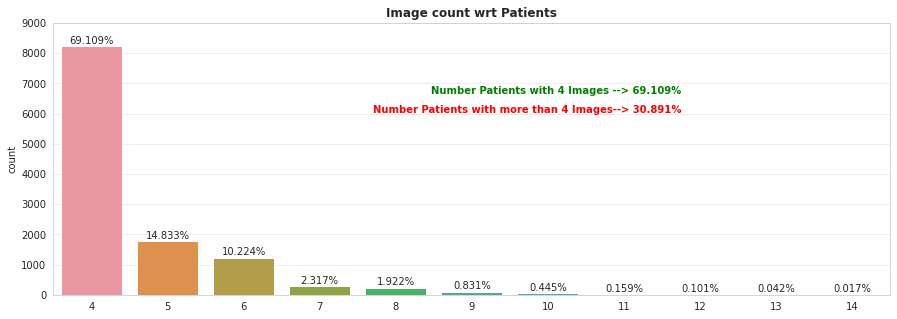

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(15,5))

ax = sns.countplot(train.groupby('patient_id').size())
t=train['patient_id'].nunique();ax.set_title('Image count wrt Patients', fontweight='bold');ax.set_ylim(0,9000) 

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
ax.text(x=0.75, y=0.77, transform=ax.transAxes, s="Number Patients with 4 Images --> 69.109%", fontsize=10, color='green', fontweight='bold', verticalalignment='top', horizontalalignment='right')
ax.text(x=0.75, y=0.70, transform=ax.transAxes, s="Number Patients with more than 4 Images--> 30.891%", fontsize=10, color='red',   fontweight='bold', verticalalignment='top', horizontalalignment='right')

plt.show()


* For 69.109% of patients, the number of images taken is 4 and for rest 30.891% the number of image taken is more than 4. 

* **Let us check if  number of images taken have any correlation with** :
    * The  patient cancer status
    * The site of visit of patients

## Image Analysis wrt to Patient Cancer Status

cured_list -> completely cured data
list_c_0.append(temp_df.patient_id.unique()[i]) - > Patients with starting 0 then 1 then 0 then 1
list_counter_0_1_0_1.append(temp_df.patient_id.unique()[i]) - > 0 1 0 1
list_counter_0_0_1_1.append(temp_df.patient_id.unique()[i]) -> 0 0 1 1
list_c_1.append(temp_df.patient_id.unique()[i]) - > Provide patients having starting 1 and in between 0 and finally then 1

In [16]:
cancer_false_df = train[train['patient_id'].isin(cancer_unique[cancer_unique['cancer']==0]['patient_id'].unique())]
cancer_true_df = train[train['patient_id'].isin(cancer_unique[cancer_unique['cancer']==1]['patient_id'].unique())]
completely_cured_df = train[train['patient_id'].isin(train[train['image_id'].isin(cured_list)]['patient_id'].unique())]
cancer_0_1_0_1_df = train[train['patient_id'].isin(list_counter_0_1_0_1)]
cancer_0_0_1_1_df = train[train['patient_id'].isin(list_counter_0_0_1_1)]
cancer_1_0_1_df = train[train['patient_id'].isin(list_c_1)]

In [17]:
display_html("<h3><br/>To analyze the  patient cancer status wrt images taken, below details are also used",raw=True)
cancer_df['Normalize'] = cancer_df['Count']/cancer_df['Count'].sum()*100
cancer_df.style.background_gradient(cmap='viridis_r')

To analyze the patient cancer status wrt images taken, below details are also used

,Count,Normalize
Patients Cancer Status,,
Cancer Stats False from Beginning,11427,95.920423
Cancer Stats True from Beginning,6,0.050365
Completely Cured,235,1.972635
"Cancer Stats False Turned True then False, Finally True",90,0.755477
Cancer Stats Truned True,66,0.554017
"Cancer Stats True Turned False, Finally True",89,0.747083


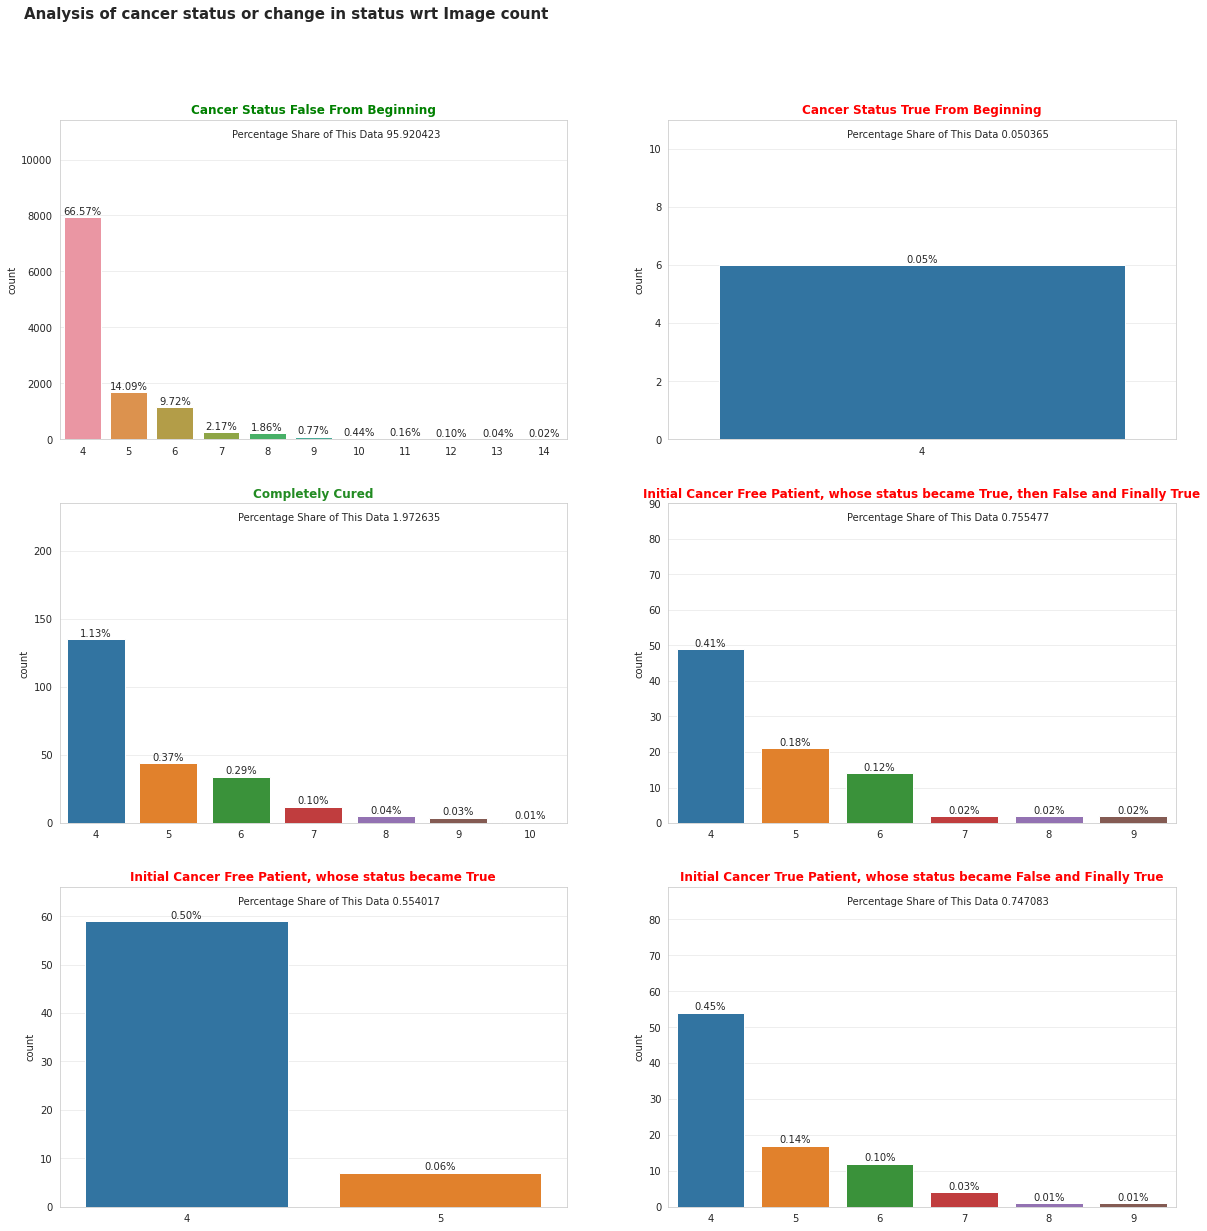

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))
fig.text(0.1, 0.95, "Analysis of cancer status or change in status wrt Image count", fontsize=15, fontweight='bold')  

sns.countplot(cancer_false_df.groupby('patient_id').size(),ax=ax[0,0])
sns.countplot(cancer_true_df.groupby('patient_id').size(),ax=ax[0,1])
sns.countplot(completely_cured_df.groupby('patient_id').size(),ax=ax[1,0])
sns.countplot(cancer_0_1_0_1_df.groupby('patient_id').size(),ax=ax[1,1])
sns.countplot(cancer_0_0_1_1_df.groupby('patient_id').size(),ax=ax[2,0])
sns.countplot(cancer_1_0_1_df.groupby('patient_id').size(),ax=ax[2,1])

t = train.patient_id.nunique()
    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
    if i==0:   ax.set_ylim(0, cancer_false_df.patient_id.nunique())    ;ax.set_title('Cancer Status False From Beginning', fontweight='bold', color = 'green');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[0], fontsize=10, verticalalignment='top', horizontalalignment='right')
    elif i==1: ax.set_ylim(0, cancer_true_df.patient_id.nunique()+5)   ;ax.set_title('Cancer Status True From Beginning', fontweight='bold', color = 'red');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[1], fontsize=10, verticalalignment='top', horizontalalignment='right')
    elif i==2: ax.set_ylim(0, completely_cured_df.patient_id.nunique());ax.set_title('Completely Cured',fontweight='bold', color = 'forestgreen');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[2], fontsize=10, verticalalignment='top', horizontalalignment='right')        
    elif i==3: ax.set_ylim(0, cancer_0_1_0_1_df.patient_id.nunique())  ;ax.set_title('Initial Cancer Free Patient, whose status became True, then False and Finally True',fontweight='bold', color = 'red');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[3], fontsize=10, verticalalignment='top', horizontalalignment='right')        
    elif i==4: ax.set_ylim(0, cancer_0_0_1_1_df.patient_id.nunique())  ;ax.set_title('Initial Cancer Free Patient, whose status became True',fontweight='bold', color = 'red');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[4], fontsize=10, verticalalignment='top', horizontalalignment='right')        
    elif i==5: ax.set_ylim(0, cancer_1_0_1_df.patient_id.nunique())    ;ax.set_title('Initial Cancer True Patient, whose status became False and Finally True',fontweight='bold', color = 'red');ax.text(x=0.75, y=0.97, transform=ax.transAxes, s="Percentage Share of This Data %f" % cancer_df['Normalize'].values[5], fontsize=10, verticalalignment='top', horizontalalignment='right')        

        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
        

    
plt.show()

* 11 or more images are taken for cancer Free Patients, Is it due to routine checkup ?

* Only 4 Images are taken for patients whose cancer status is True from beginning, and which remains the same.

* 94.38% of completely cured patients only 4 images are taken, and there is decrease in number of patients with increase in photos taken. Is it due to status change of cancer detection ?

* only for 10% of Patients whose Inital Status was False and Turned to True 5 images where taken and for rest only 4 images where taken.

* More than 4 images are taken for 43.33% of Patients whose cancer status was initial True, then became False and Then True and Patients whose cancer status was False, then True, then False and finally True have more than. May be number of images are increased as the status changed more than 2 times.


# Site Analysis and Image Analysis wrt Sites

In [19]:
site_1 = train[train['site_id']==1];site_2 = train[train['site_id']==2]

l1 = list(site_1.patient_id.unique());l2 = list(site_2.patient_id.unique())

print(site_1[site_1.patient_id.isin(l2)])
print(site_2[site_2.patient_id.isin(l1)])

final_site_1 = site_1.drop_duplicates(keep='first',subset="patient_id")
final_site_2 = site_2.drop_duplicates(keep='first',subset="patient_id")

display_html(f"<h3><br/>Number of Patients Visiting site_1 is {round(final_site_1.shape[0]/train.patient_id.nunique()*100,2)}%, and visiting site_2 is {round(final_site_2.shape[0]/train.patient_id.nunique()*100,2)}%", raw = True)

Empty DataFrame
Columns: [site_id, patient_id, image_id, laterality, view, age, cancer, biopsy, invasive, BIRADS, implant, density, machine_id, difficult_negative_case]
Index: []
Empty DataFrame
Columns: [site_id, patient_id, image_id, laterality, view, age, cancer, biopsy, invasive, BIRADS, implant, density, machine_id, difficult_negative_case]
Index: []


Number of Patients Visiting site_1 is 48.84%, and visiting site_2 is 51.16%

In [20]:
## Image Dataset with more than 4 image count 
df = train.groupby('patient_id').size().to_frame(name='count')
image_df = train[train['patient_id'].isin(df[df['count']>4].index.to_list())]
image_df_drop_dup= image_df.drop_duplicates(keep='first',subset="patient_id")
patient_more_4Img_list = list(image_df_drop_dup['patient_id'].values)

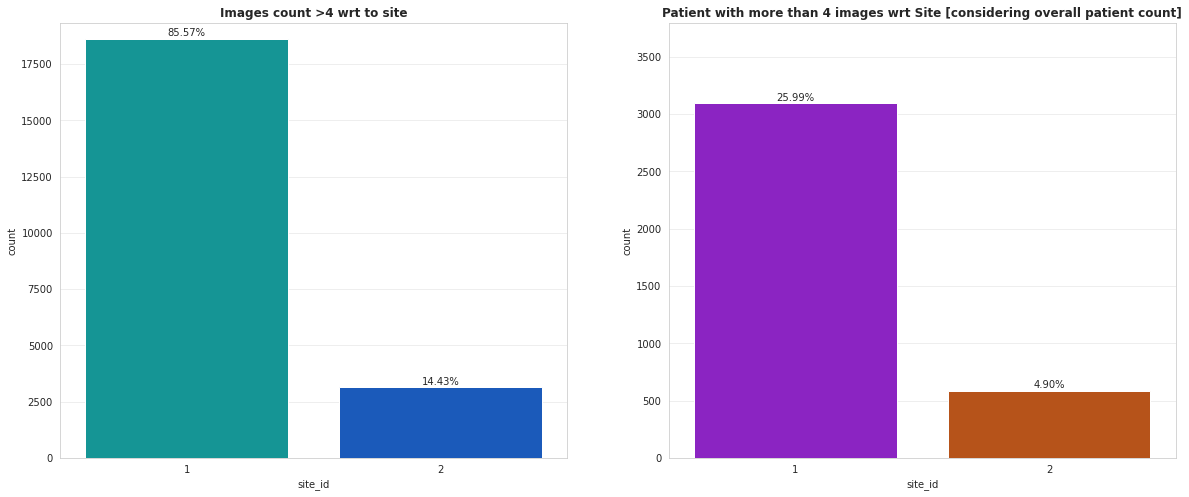

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
#fig.text(0.1, 0.95, "Site analysis ", fontsize=15, fontweight='bold')  

sns.countplot(data=image_df, x='site_id',palette="winter_r", ax=ax[0])
sns.countplot(data=image_df_drop_dup, x='site_id',palette="gnuplot", ax=ax[1])

    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
    if i==0:t = image_df.shape[0];ax.set_title('Images count >4 wrt to site', fontweight='bold');ax.set_ylim(0,image_df.site_id.value_counts().values[0]+700) 
    else:t = train.patient_id.nunique();ax.set_ylim(0, image_df_drop_dup.site_id.value_counts().values[0]+700);ax.set_title('Patient with more than 4 images wrt Site [considering overall patient count]',fontweight='bold')
        
        
        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
           
plt.show()

* No patient is visiting both sites

* Number of Patients Visiting site_1 is 48.84%, and visiting site_2 is 51.16%

* For more than 4 images :

   * 1. There is total of  71.199% more images taken at site_1 than at site_2
   
   * 2. Out of overall Patients, for 25.99% more than 4 images are taken from site 1
   
   * 3. Out of overall Patients, for 4.9% more than 4 images are taken from site 2
     
   * 4. While there are only 2.319% more patients visiting site_1, there is a 21.0899% increase in number of images taken at site_1 wrt to patients.[considering overall patient count]


In [22]:
false_temp = cancer_false_df[cancer_false_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
s1 = cancer_false_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");false_temp = false_temp.merge(s1, how ='inner', on='patient_id')
false_temp['cancer_status']='false'


#true_temp = cancer_true_df[cancer_true_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
#s2 = cancer_true_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");true_temp.merge(s2, how ='inner', on='patient_id')
#true_temp['cancer_status']= 'true'

cured_temp = completely_cured_df[completely_cured_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
s3 = completely_cured_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");cured_temp = cured_temp.merge(s3, how ='inner', on='patient_id')
cured_temp['cancer_status']= 'completely_cured'

cancer_0_1_0_1_temp = cancer_0_1_0_1_df[cancer_0_1_0_1_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
s4 = cancer_0_1_0_1_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");cancer_0_1_0_1_temp = cancer_0_1_0_1_temp.merge(s4, how ='inner', on='patient_id')
cancer_0_1_0_1_temp['cancer_status'] = 'false_tured_true_false_true'


cancer_0_0_1_1_temp = cancer_0_0_1_1_df[cancer_0_0_1_1_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
s5 = cancer_0_0_1_1_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");cancer_0_0_1_1_temp = cancer_0_0_1_1_temp.merge(s5, how ='inner', on='patient_id')
cancer_0_0_1_1_temp['cancer_status'] = 'false_turned_true'


cancer_1_0_1_temp = cancer_1_0_1_df[cancer_1_0_1_df.patient_id.isin(patient_more_4Img_list)].groupby('patient_id').size().reset_index(name='image_counts')
s6 = cancer_1_0_1_df[['patient_id','site_id']].drop_duplicates(keep='first',subset="patient_id");cancer_1_0_1_temp = cancer_1_0_1_temp.merge(s6, how ='inner', on='patient_id')
cancer_1_0_1_temp['cancer_status']= 'true_turned_false_true'


image_count_gr4_df = pd.concat([false_temp,cured_temp,cancer_0_1_0_1_temp,cancer_0_0_1_1_temp,cancer_1_0_1_temp]);image_count_gr4_df['site_id'] = image_count_gr4_df['site_id'].astype(int)
image_count_gr4_df

,patient_id,image_counts,site_id,cancer_status
0,25,6,1,false
1,33,5,1,false
2,36,5,2,false
3,49,5,1,false
4,72,5,1,false
...,...,...,...,...
30,53636,7,1,true_turned_false_true
31,57229,6,1,true_turned_false_true
32,59806,5,1,true_turned_false_true
33,62608,8,1,true_turned_false_true


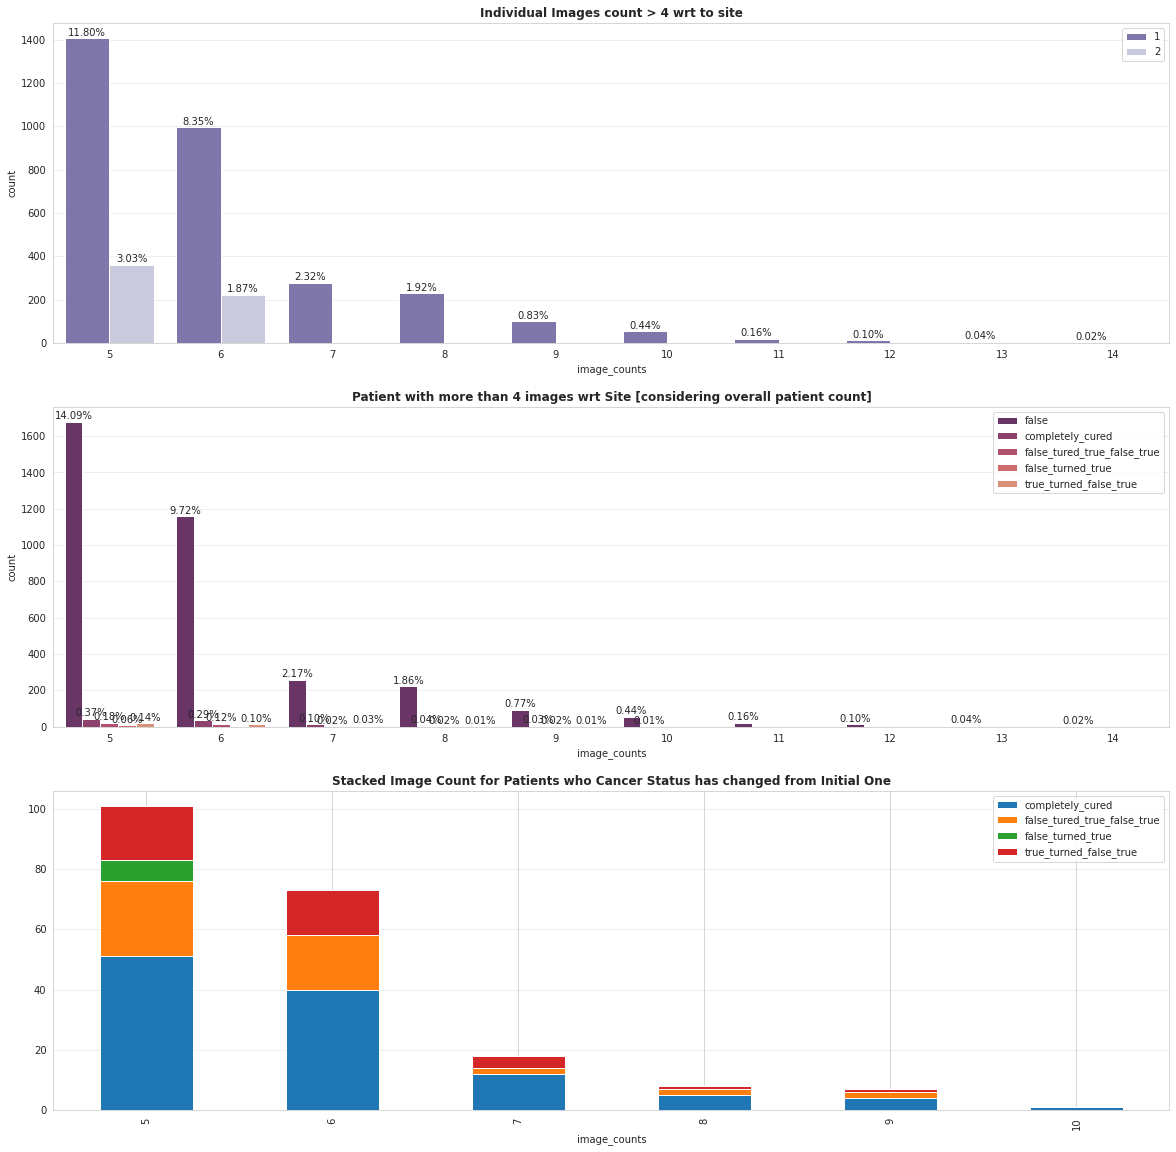

In [23]:
temp = image_count_gr4_df[image_count_gr4_df['cancer_status']!='false']
df_pivot = pd.pivot_table(temp, index='image_counts', columns='cancer_status', values='site_id', aggfunc='sum')

fig, ax = plt.subplots(3, 1, figsize=(20,20))

sns.countplot(x='image_counts', hue = 'site_id', data=image_count_gr4_df,palette="Purples_r", ax =ax[0]);ax[0].set_title('Individual Images count > 4 wrt to site', fontweight='bold')
sns.countplot(x='image_counts', hue = 'cancer_status', data=image_count_gr4_df,palette="flare_r", ax =ax[1]);ax[1].set_title('Patient with more than 4 images wrt Site [considering overall patient count]',fontweight='bold')
df_pivot.plot.bar(stacked=True, ax =ax[2]);ax[2].set_title('Stacked Image Count for Patients who Cancer Status has changed from Initial One',fontweight='bold')
    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    ax.legend(loc='upper right')
                  
    if i!=2:
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / t:.2f}%\n'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
    
plt.show()

# laterality 

- laterality - Whether the image is of the left or right breast.

- view - The orientation of the image. The default for a screening exam is to capture two views per breast.


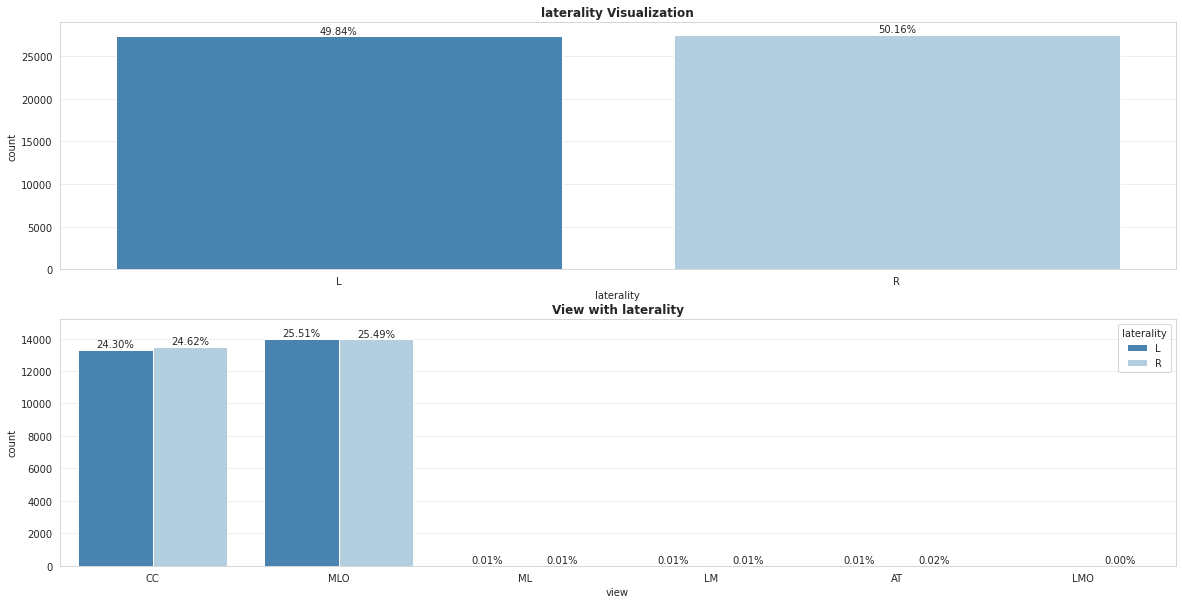

In [24]:
fig, ax = plt.subplots(2,1, figsize=(20,10)) 

sns.countplot(data=train, x='laterality',palette= 'Blues_r', ax=ax[0])
sns.countplot(data=train, x='view', hue='laterality',palette="Blues_r", ax=ax[1])
t = train.shape[0]
    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
    if i==0:ax.set_title('laterality Visualization', fontweight='bold');ax.set_ylim(0,train.laterality.value_counts().values[0]+1500) 
    else:ax.set_ylim(0, train.laterality.value_counts().values[0]/2+1500);ax.set_title('View with laterality',fontweight='bold')
        
        
        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
           
plt.show()

* When we check laterality for overall data, there is no much difference. But we have around 18.19% of odd image count odd. Will have to check if there is any relation between these two ?

* As per data description, view provide the orientation of the image. The default for a screening exam is to capture two views per breast.

    * Here we have 51.01% of MLO and 48.93%of CC and it is almost same for left and right laterality
    
    *  We have ML(medio-lateral view) - 0.01%, latero-medial view - 0.02%, LMO (lateral-medial oblique) -0.0018% 
    
        * [Document ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113143/#:~:text=In%20screening%20digital%20mammography%2C%20each,taken%20from%20above%20the%20breast.) states In screening digital mammography, each breast is typically imaged with two different views, i.e., the mediolateral oblique (MLO) view and cranial caudal (CC) view . The MLO view is taken from the center of the chest outward, while the CC view is taken from above the breast. --> Which is in par with the visualization.
        
    *  We have ML(medio-lateral view) - 0.01%, latero-medial view - 0.02%, LMO (lateral-medial oblique) -0.0018% 
       
      

Let us analyze laterality and CC and ML view with respect to image count


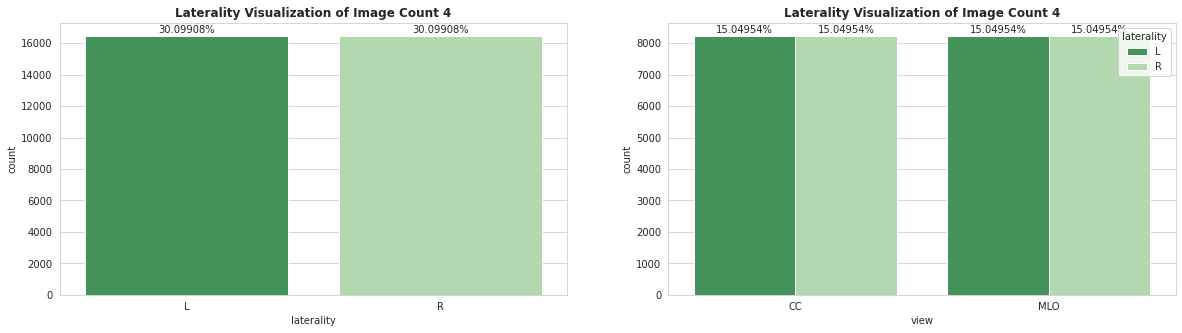

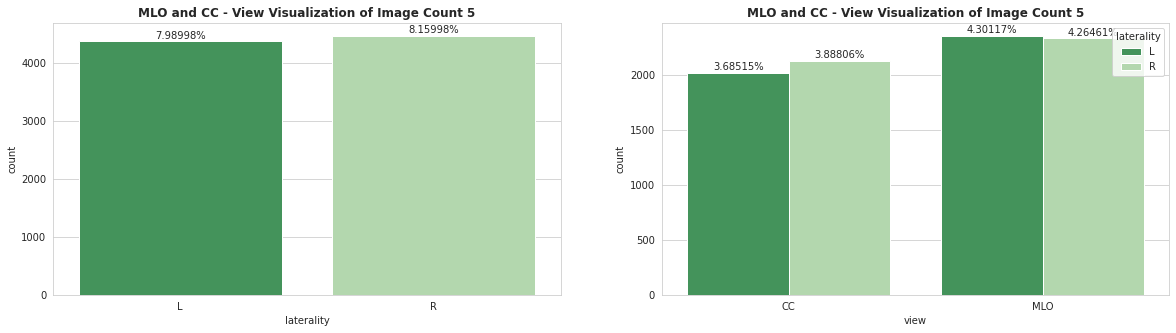

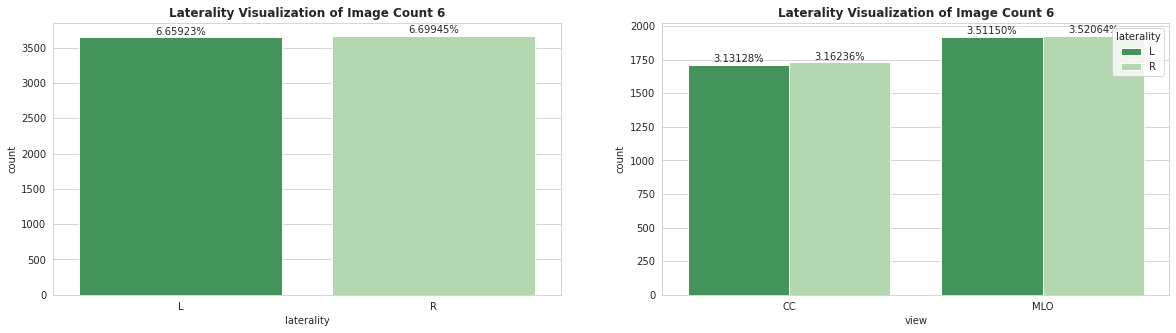

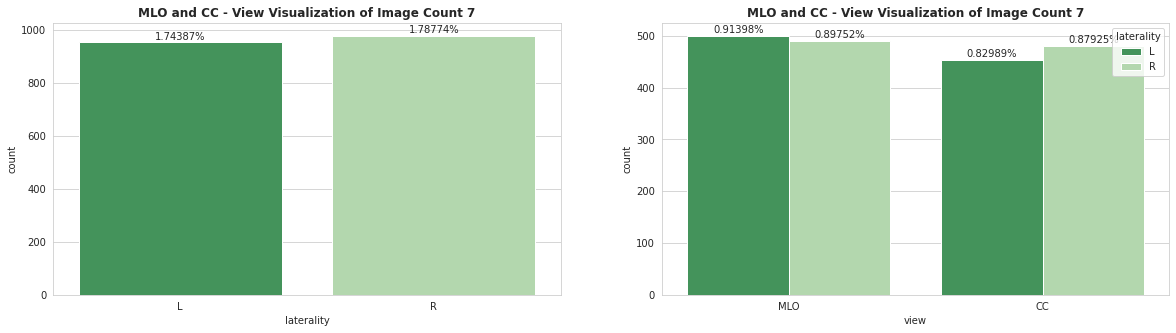

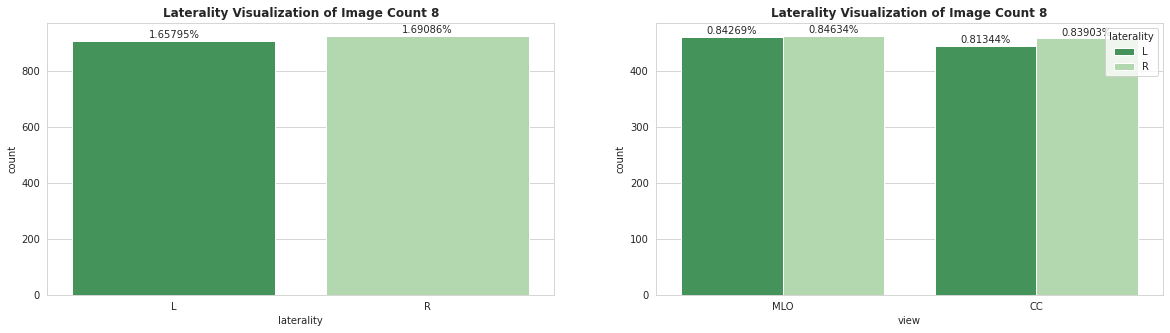

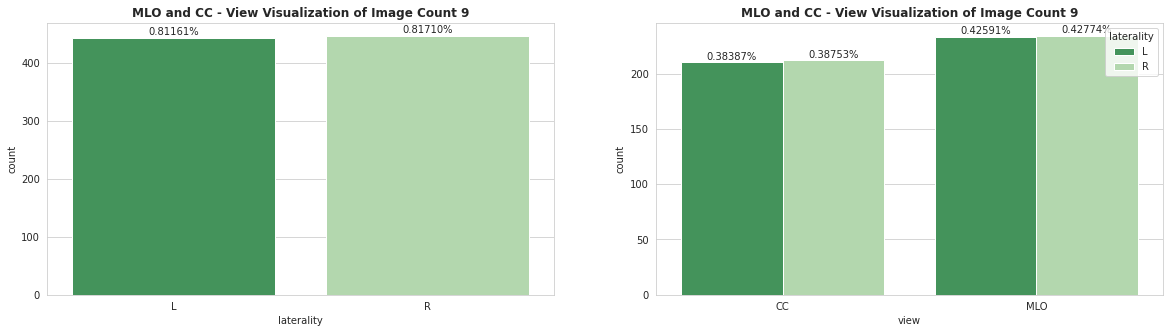

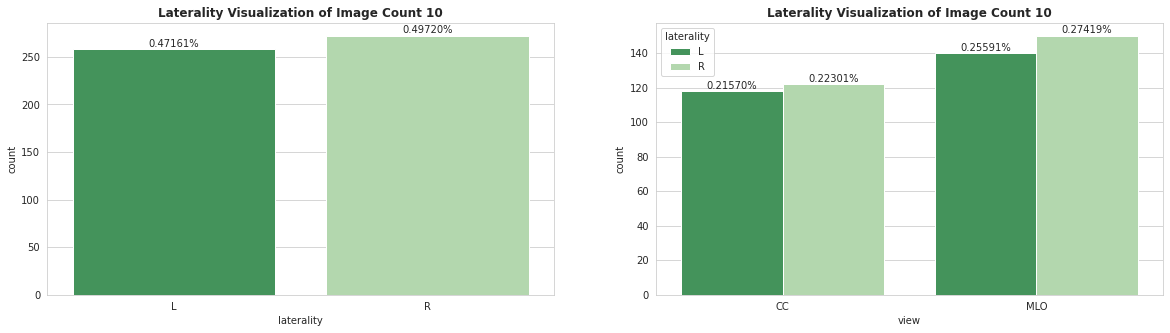

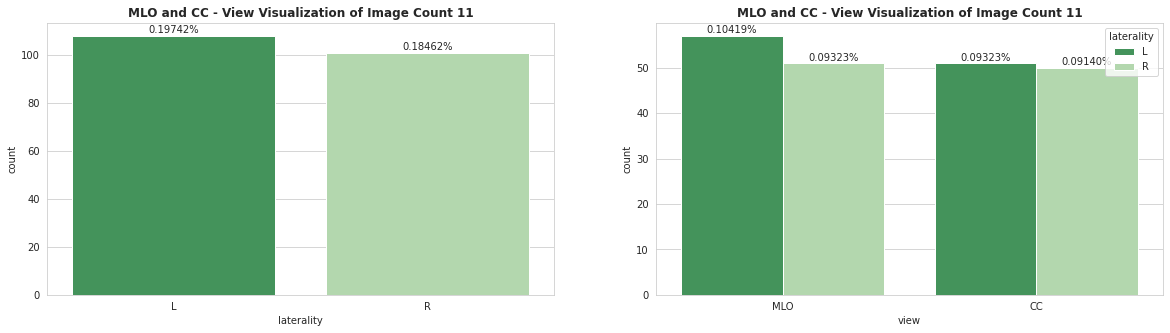

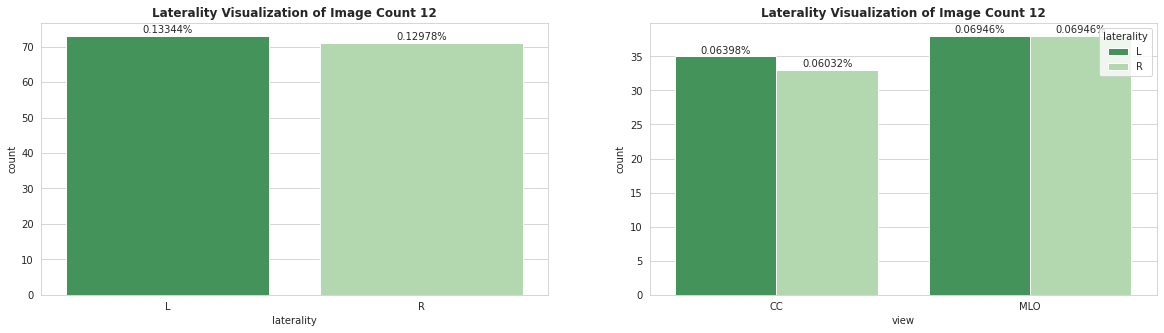

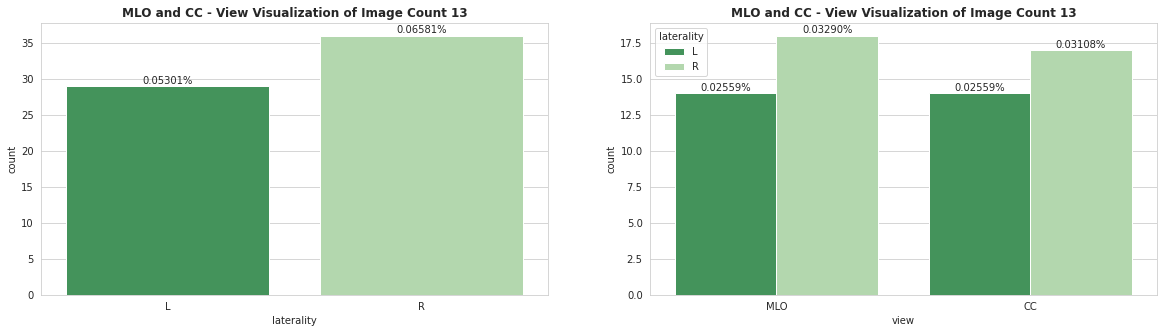

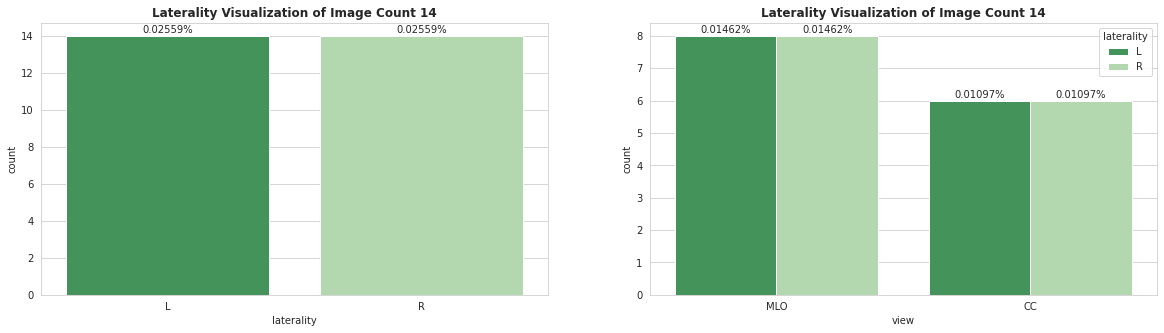

In [25]:
for i in range(len(df['count'].value_counts().index)):
    temp_img_df  = train[train['patient_id'].isin(df[df['count']==df['count'].value_counts().index[i]].index.to_list())]
    temp_img_view = temp_img_df[temp_img_df['view'].isin(['MLO','CC'])]
    
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    sns.countplot(data=temp_img_df, x='laterality',palette= 'Greens_r', ax=ax[0])
    sns.countplot(data=temp_img_view, x='view', hue='laterality',palette="Greens_r", ax=ax[1])  

    t = train.shape[0];
   
    for j, ax in enumerate(ax.flatten()):
        if i%2 ==0: title = 'Laterality Visualization of Image Count ' + str(df['count'].value_counts().index[i])
        else: title = 'MLO and CC - View Visualization of Image Count ' + str(df['count'].value_counts().index[i])
            
        ax.set_title(title, fontweight='bold')
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / t:.5f}%\n'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
           
        
        
plt.show()

# biopsy

biopsy indicates whether or not a follow-up biopsy was performed on the breast.

In [26]:
train.groupby('cancer').biopsy.value_counts(normalize=True).mul(100).round(2).reset_index(name='biopsy_done_percentage')

,cancer,biopsy,biopsy_done_percentage
0,0,0,96.62
1,0,1,3.38
2,1,1,100.00


* Patient who have cancer status True, had done with 100% biopsy.

* Only 3.38% of patients who have latest status have False is done with biopsy. 

To understand this 3.38% of data, will have to analyze 

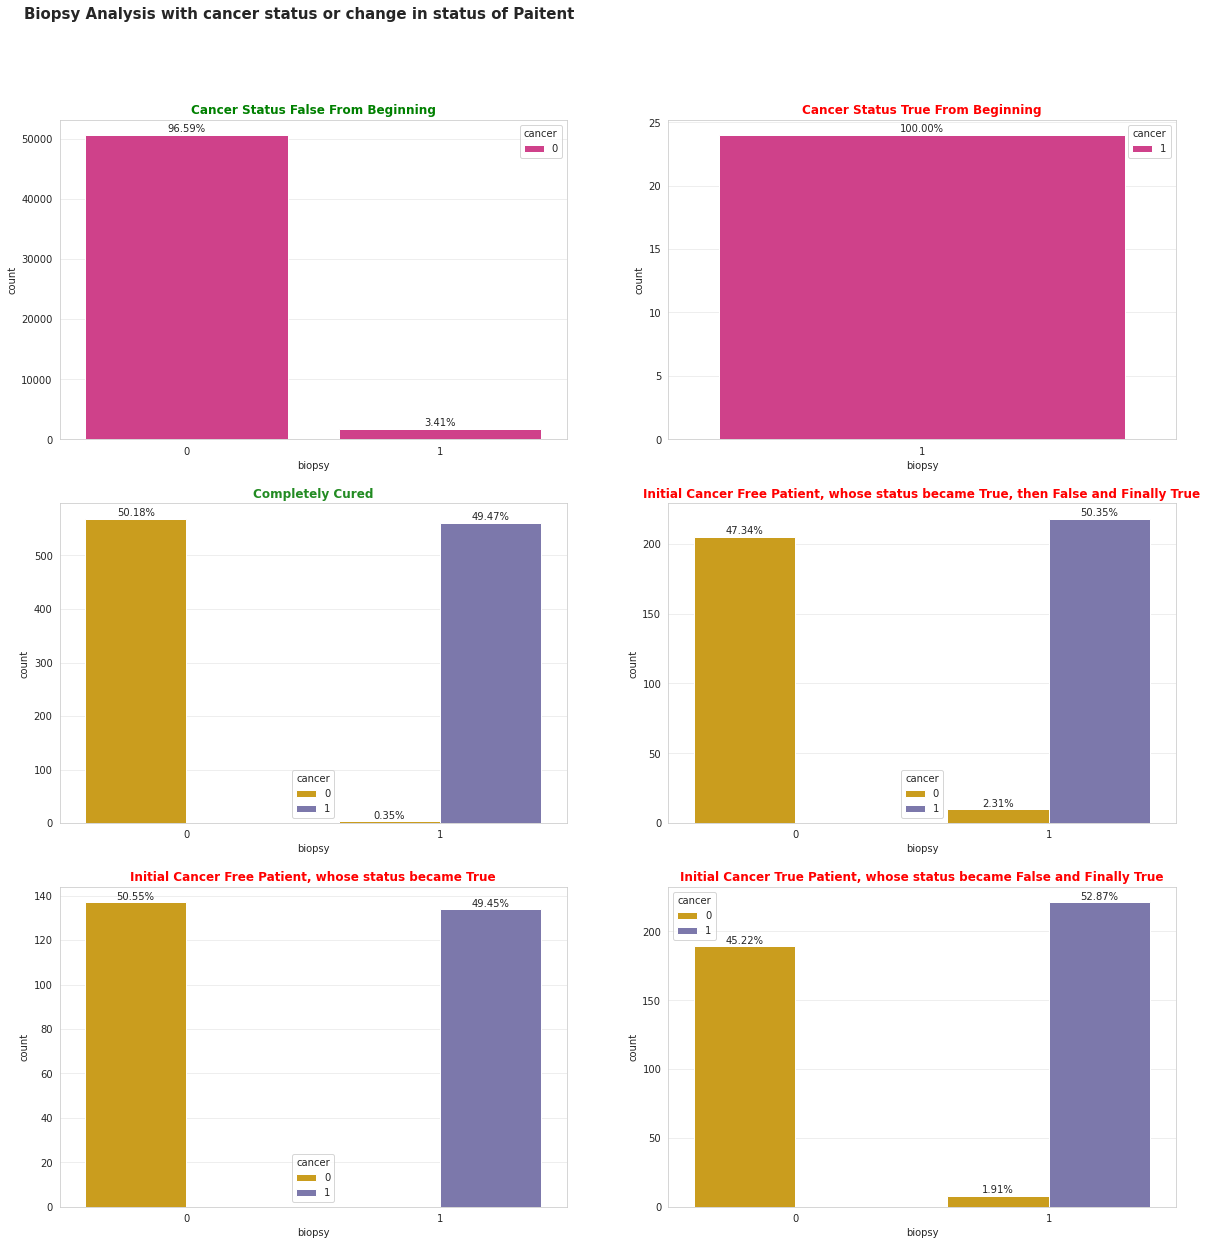

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))
fig.text(0.1, 0.95, "Biopsy Analysis with cancer status or change in status of Paitent", fontsize=15, fontweight='bold')  

sns.countplot(data = cancer_false_df, x ='biopsy',hue='cancer', palette= 'Dark2_r',ax=ax[0,0])
sns.countplot(data = cancer_true_df, x ='biopsy',hue='cancer',palette= 'Dark2_r',ax=ax[0,1])
sns.countplot(data = completely_cured_df, x ='biopsy',hue='cancer',palette= 'Dark2_r',ax=ax[1,0])
sns.countplot(data = cancer_0_1_0_1_df, x ='biopsy',hue='cancer',palette= 'Dark2_r',ax=ax[1,1])
sns.countplot(data = cancer_0_0_1_1_df, x ='biopsy',hue='cancer',palette= 'Dark2_r',ax=ax[2,0])
sns.countplot(data = cancer_1_0_1_df, x = 'biopsy',hue='cancer',palette= 'Dark2_r',ax=ax[2,1])

    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    if   i==0: ax.set_title('Cancer Status False From Beginning', fontweight='bold', color = 'green'); t=cancer_false_df.shape[0]
    elif i==1: ax.set_title('Cancer Status True From Beginning', fontweight='bold', color = 'red');t = cancer_true_df.shape[0]
    elif i==2: ax.set_title('Completely Cured',fontweight='bold', color = 'forestgreen');t = completely_cured_df.shape[0]
    elif i==3: ax.set_title('Initial Cancer Free Patient, whose status became True, then False and Finally True',fontweight='bold', color = 'red');t = cancer_0_1_0_1_df.shape[0]
    elif i==4: ax.set_title('Initial Cancer Free Patient, whose status became True',fontweight='bold', color = 'red');t = cancer_0_0_1_1_df.shape[0]
    elif i==5: ax.set_title('Initial Cancer True Patient, whose status became False and Finally True',fontweight='bold', color = 'red');t = cancer_1_0_1_df.shape[0]      
        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
        

    
plt.show()

* 2.31% of Patients whose Cancer Status was initially False, which turn became True, then False and Finally True,**biopsy was taken** when there Cancer status was False

* 1.191% of Patients whose Cancer Status was initially True,  which status became False and Finally True , **biopsy was taken** when there Cancer status was False

* None of Patients whose initial status was False and become True biopsy was taken in the cancer False status

# invasive  

* invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.



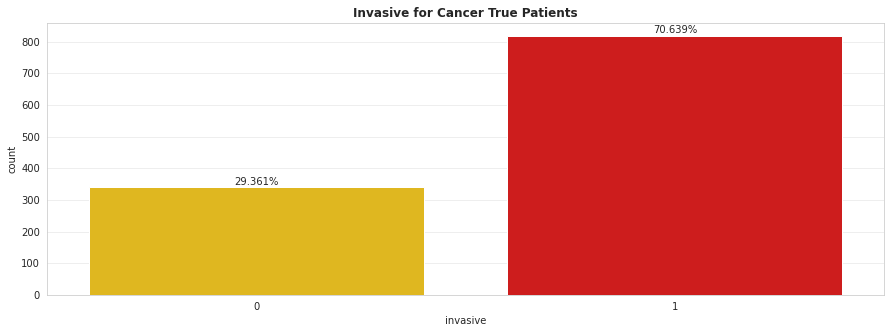

In [28]:
cancer_true = train[train.cancer==1]
plt.figure(figsize=(15,5))

ax = sns.countplot(data = cancer_true, x = 'invasive', palette='hot_r')
t=cancer_true['patient_id'].shape[0];ax.set_title('Invasive for Cancer True Patients', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
plt.show()

* 70.639% of cancer True Patients, have invasive as 1, which is a serious concern.

# BIRADS

* BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.

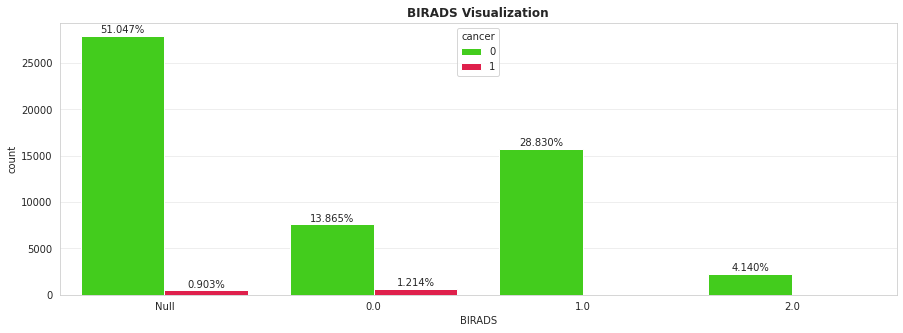

In [29]:
plt.figure(figsize=(15,5))
temp = train.copy();temp.BIRADS.fillna('Null', inplace=True)

ax = sns.countplot(data = temp, x = 'BIRADS', hue='cancer', palette='prism')
t=train.shape[0];ax.set_title('BIRADS Visualization', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
plt.show()

In [30]:
train[train.BIRADS.isnull()]['cancer'].value_counts()[0]/train.cancer.value_counts()[0]

0.5215134085306641

* 4.140% of patients breast was rated as normal and it belongs to cancer False patients

* 28.230% of patients breast was rated as cancer negative.

* 42.66% of cancer true patients, and 52.15% of cancer false patients BIRADS parameter is null.




# implant

implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.

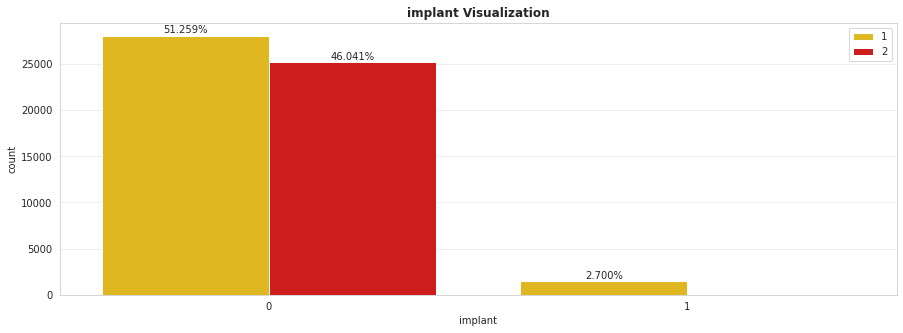

In [31]:
plt.figure(figsize=(15,5))

ax = sns.countplot(data = train, x = 'implant', hue='site_id', palette='hot_r')
t=train.shape[0];ax.set_title('implant Visualization', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    ax.legend(loc='upper right')
    
plt.show()

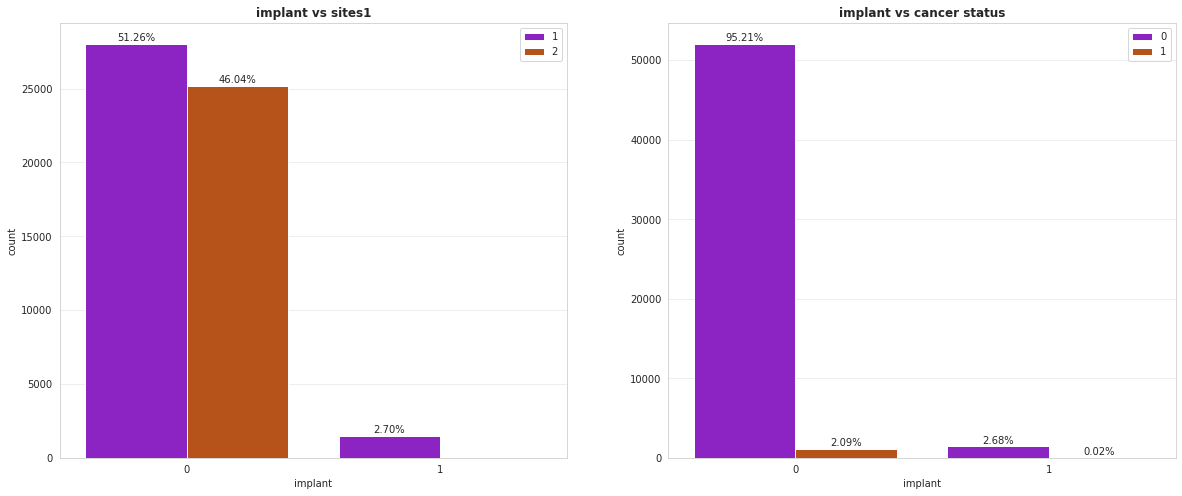

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.countplot(data = train, x = 'implant', hue='site_id', palette='gnuplot',ax = ax[0])
sns.countplot(data = train, x = 'implant', hue='cancer', palette='gnuplot',ax=ax[1])
t=train.shape[0]

    
for i, ax in enumerate(ax.flatten()):
    ax.grid(axis='y', linestyle='-', alpha=0.4) 
    
    if i==0:ax.set_title('implant vs sites1', fontweight='bold')
    else:ax.set_title('implant vs cancer status',fontweight='bold')
        
        
        
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.2f}%\n'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2,p.get_height()), ha='center', va='center')
        ax.legend(loc='upper right')
           
plt.show()

* Implant is done only in site_id 1 and it is only 2.7%

* Out of 2.7% implant done only 2.68% is having cancer status as False and 0.02% as True

# Density

density - A rating for how dense the breast tissue is, with **A being the least dense** and **D being the most dense**. Extremely dense tissue can make diagnosis more difficult. 

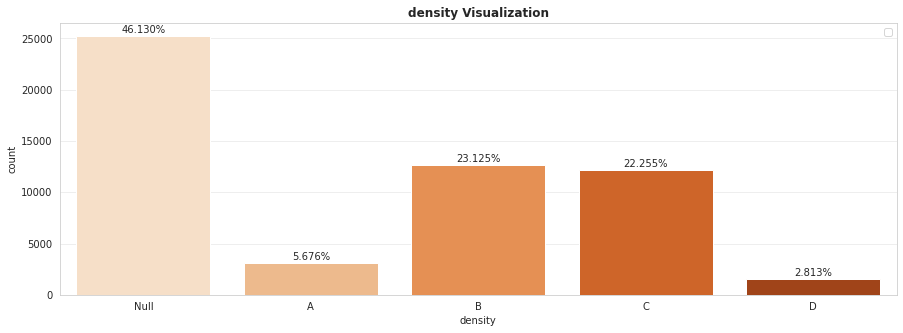

In [33]:
temp = train.copy();temp.density.fillna('Null', inplace=True)

plt.figure(figsize=(15,5))

ax = sns.countplot(data = temp, x = 'density',order=['Null','A','B','C','D'],palette='Oranges')
t=train.shape[0];ax.set_title('density Visualization', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    ax.legend(loc='upper right')
    
plt.show()

* 46.1330% of paitents density parameter is null

* 2.813% is having very dense breast tissue, which will be difficult to diaganosis

# machine_id

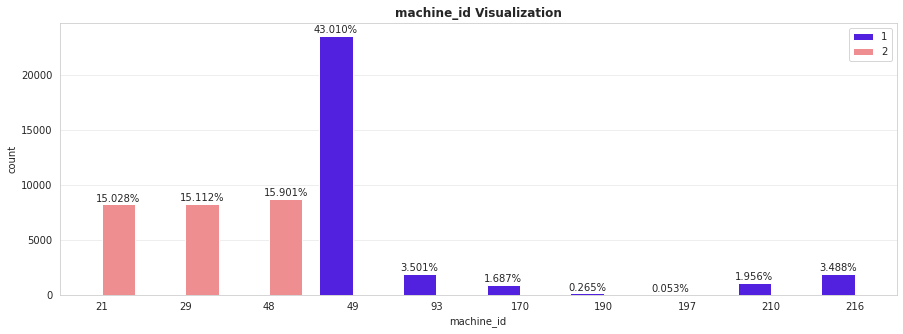

In [34]:
plt.figure(figsize=(15,5))

ax = sns.countplot(data = temp, x = 'machine_id',hue='site_id', palette='gnuplot2')
t=train.shape[0];ax.set_title('machine_id Visualization', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    ax.legend(loc='upper right')
    
plt.show()

* Machine id 21, 29 and 48 are used in site_2 and rest machines in site_1

* 79.708% of patients of site_1 is analyed using machine ID 49

# difficult_negative_case

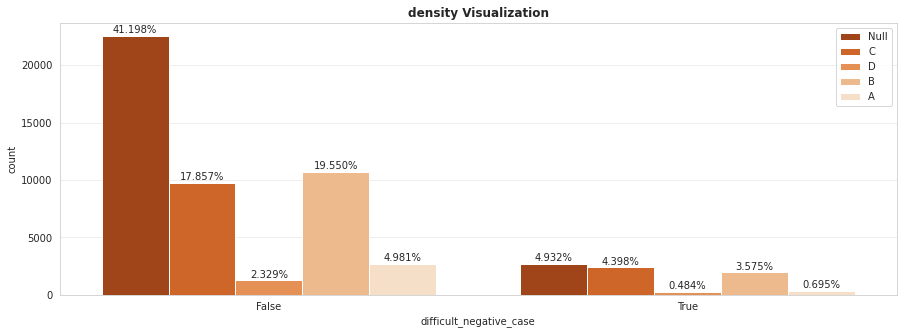

In [35]:
train.difficult_negative_case.value_counts()

temp = train.copy();temp.density.fillna('Null', inplace=True)

plt.figure(figsize=(15,5))

ax = sns.countplot(data = temp, x = 'difficult_negative_case',hue = 'density',palette='Oranges_r')
t=train.shape[0];ax.set_title('density Visualization', fontweight='bold')

for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.3f}%\n';x = p.get_x() + p.get_width() / 2 ; y = p.get_height();
    ax.annotate(percentage, (x, y), ha='center', va='center');ax.grid(axis='y', linestyle='-', alpha=0.4) 
    ax.legend(loc='upper right')
    
plt.show()

# Training Image analysis

## First Image in training data

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10706.1.763186195
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10706.1.763186195
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184026.815884'
(0010, 0020) Patient ID                          LO: '10706'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10706
(0020, 000e) Series Instance U

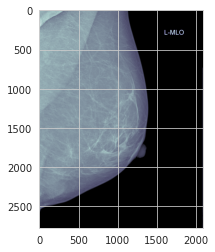

In [36]:
train_images = gb.glob('/kaggle/input/rsna-breast-cancer-detection/train_images/10**/*.dcm', recursive = True)
len(train_images)

filename = train_images[0]
dataset = dicom.dcmread(filename)
print(dataset)
print(__doc__)

print("Filename.........:", filename);
print("Patient id.......:", dataset.PatientID)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

## Image of Patient with Cancer False Patient with different color map

In [37]:
dcm_train_img_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"

def train_images(patient_id , figsize,cmap):
    fig, ax = plt.subplots(1, len(list(train[train.patient_id == patient_id].patient_id)), figsize=figsize);ax = ax.flatten()
    
    for i, dcm in enumerate(os.listdir(os.path.join(dcm_train_img_path, str(patient_id)))):
        img = (dicom.dcmread(os.path.join(dcm_train_img_path, str(patient_id), dcm))).pixel_array
        title = "Patient_id : " + str(patient_id) + ' ' + cmap + ', image - ' + str(i);ax[i].set_title(title)
        if len(cmap)==0:ax[i].imshow(img)
        else:ax[i].imshow(img, cmap=cmap);

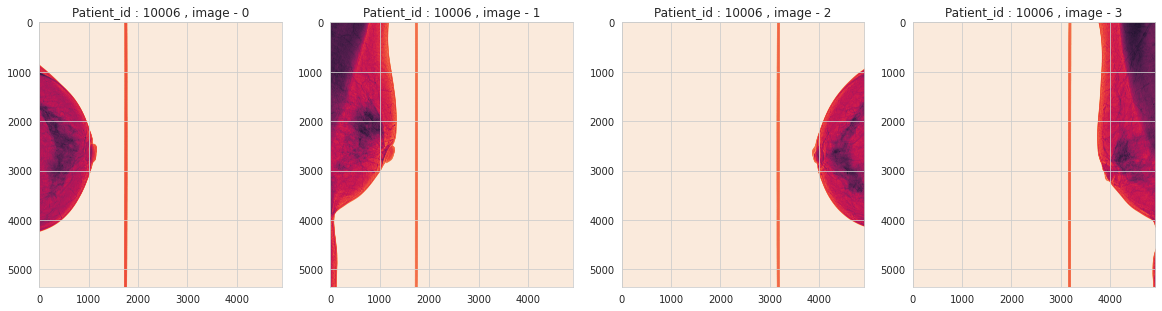

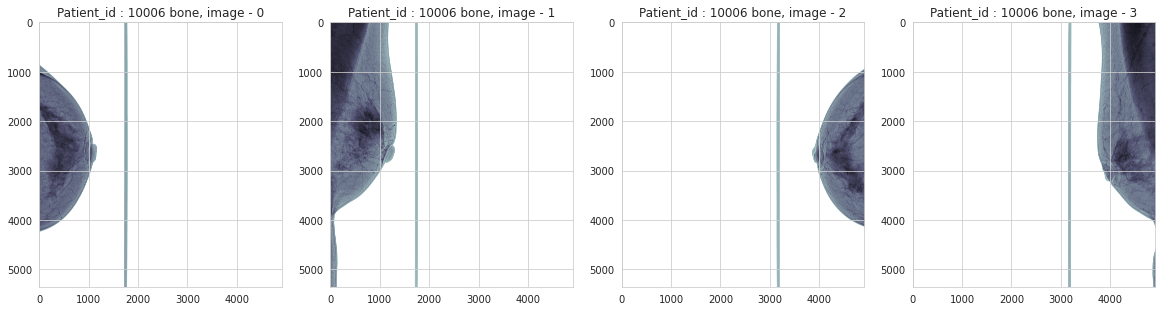

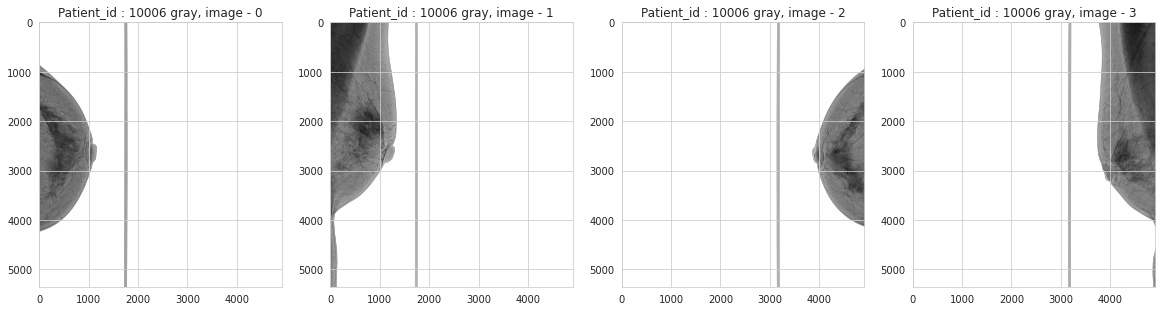

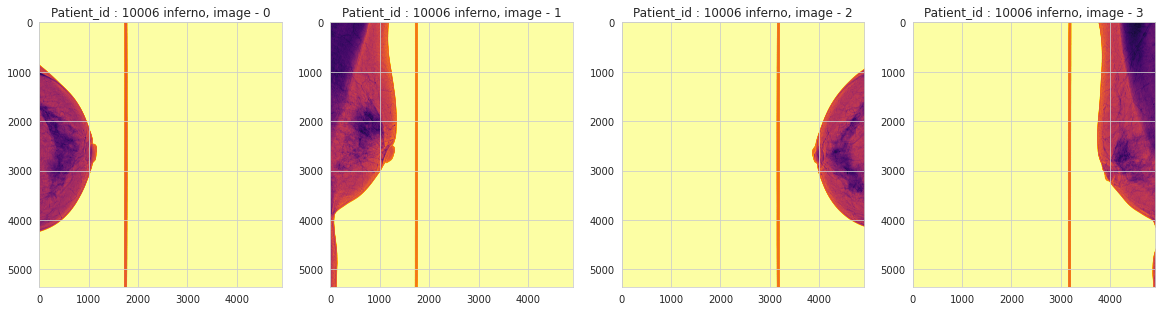

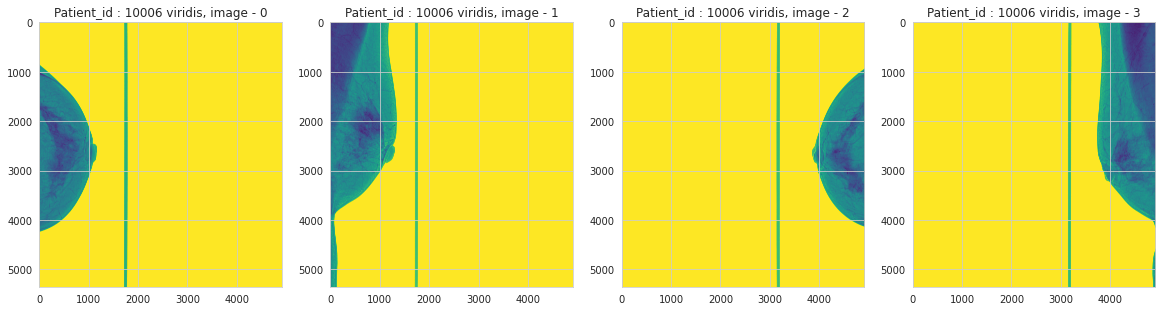

In [38]:
patient_id = cancer_false_df['patient_id'].unique()[0]
train_images(patient_id, (20,10),'')
train_images(patient_id, (20,10),'bone')
train_images(patient_id, (20,10),'gray')
train_images(patient_id, (20,10),'inferno')
train_images(patient_id, (20,10),'viridis')


## Image of Patient with Cancer True Patient from beginning and whose cancer status has not changed with different color map

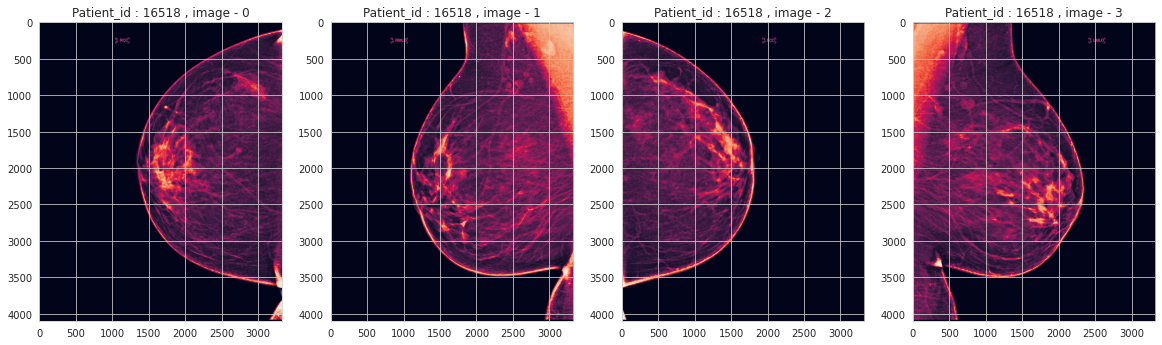

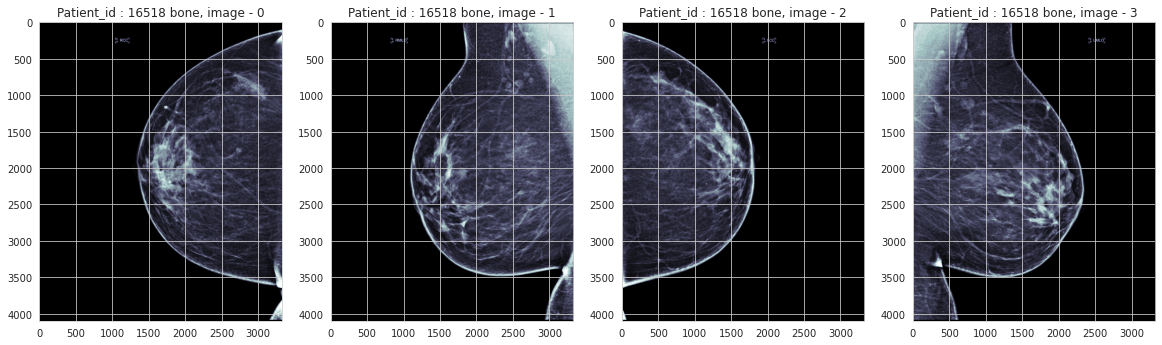

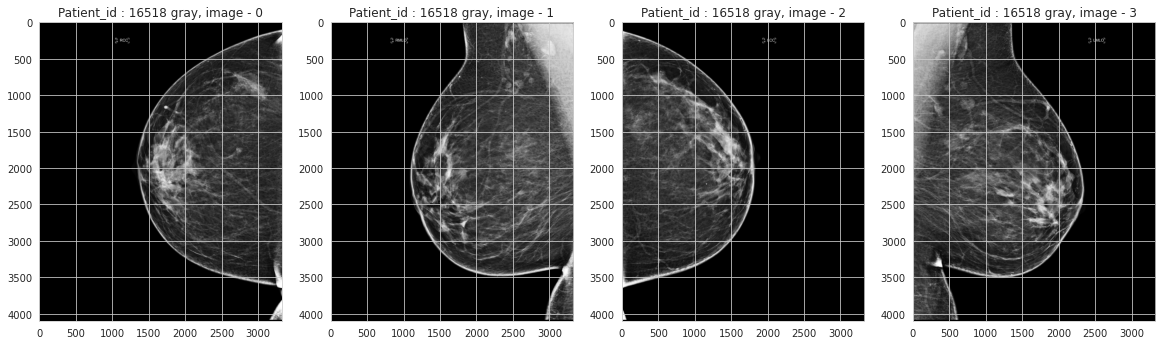

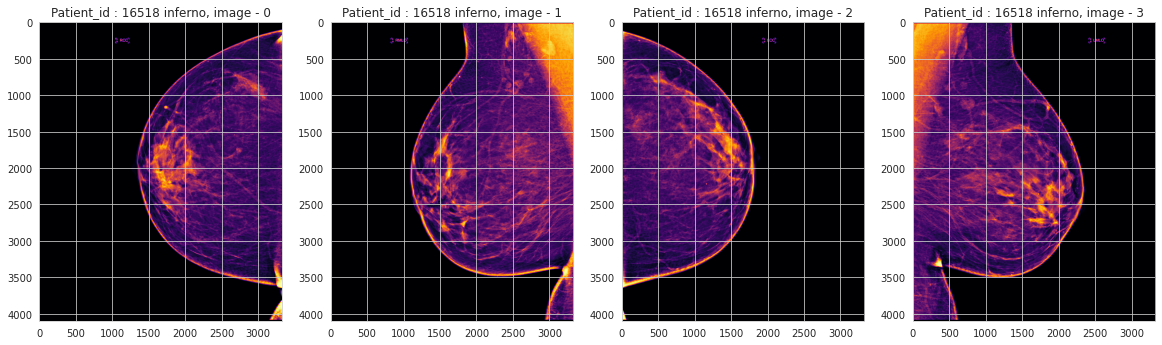

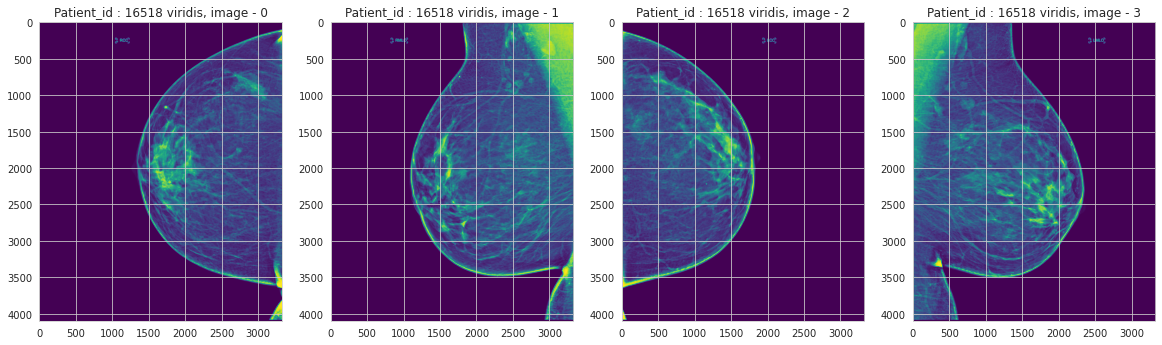

In [39]:
patient_id = cancer_true_df['patient_id'].unique()[0]

train_images(patient_id, (20,10),'')
train_images(patient_id, (20,10),'bone')
train_images(patient_id, (20,10),'gray')
train_images(patient_id, (20,10),'inferno')
train_images(patient_id, (20,10),'viridis')